In [1]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
import string
import nltk
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, kendalltau
import jieba

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Importing and Sorting

In [3]:
files = os.listdir('corpus')
files.remove('.DS_Store')
files.remove('scores_ru-en.csv')
scaler = MinMaxScaler()
for file_ in files:
  name = file_.split('-')[0] + file_.split('-')[1]
  vars()[name] = pd.read_csv(os.path.join('corpus', file_, 'scores.csv'))
  vars()[name].drop(columns = ['source', 'annotators', 'avg-score'], inplace = True)
  vars()[name]['z-score'] = scaler.fit_transform(vars()[name]['z-score'].values.reshape(-1,1)) #normalizing values betwewen 0 and 1

In [4]:
english = csen.copy()
for df in [deen, ruen, zhen]:
  english = english.append(df)

In [5]:
finnish = enfi.copy()
chinese = enzh.copy()

In [6]:
english.reset_index(drop = True, inplace = True)

# Baseline assessment before preprocessment

### Finnish & Chinese

Splitting the data for the finnish and chinese for baseline correlation assessment purposes

In [7]:
# Train, Validation & Test split
# en_train, en_dev = train_test_split(english, shuffle = True, test_size = 0.2, random_state = 7)
# en_dev, en_test = train_test_split(en_dev, shuffle = True, test_size = 0.5, random_state = 7)

fin_train, fin_dev = train_test_split(finnish, shuffle = True, test_size = 0.2, random_state = 7)
fin_dev, fin_test = train_test_split(fin_dev, shuffle = True, test_size = 0.5, random_state = 7)

ch_train, ch_dev = train_test_split(chinese, shuffle = True, test_size = 0.2, random_state = 7)
ch_dev, ch_test = train_test_split(ch_dev, shuffle = True, test_size = 0.5, random_state = 7)

Define functions that preprocess the data and compute the correlation values for the baseline

In [8]:
def dataVectorization(train, dev, test):
    """
    Function that receives train, development and test datasets and returns the sets vectorized.
    
    """    
    # Create the CountVectorizer (Bag of words) object
    baseline_encoder = CountVectorizer(max_features = 5000) # Settting limit for computational reasons
    
    train_vectorizer_reference = baseline_encoder.fit_transform(train['reference']).todense()
    train_vectorizer_translation = baseline_encoder.transform(train['translation']).todense()
    train_vectorizer = [train_vectorizer_reference, train_vectorizer_translation]
    
    for i, d in enumerate([dev, test]):
        referece_vectorized = baseline_encoder.transform(d['reference']).todense()
        translation_vectorized = baseline_encoder.transform(d['translation']).todense()
        if i == 0:
            dev_vectorizer = [referece_vectorized, translation_vectorized]
        else:
            test_vectorizer = [referece_vectorized, translation_vectorized]
    
    return train_vectorizer, dev_vectorizer, test_vectorizer

def getBaseline(reference, translation, yLabels):
    """
    Get baseline correlations for the given sets, computing the cosine similarity.
    
    """   
    cos = []
    for i in range(reference.shape[0]):
        cos.append(cosine_similarity(reference[i], translation[i])[0])
    cos = np.array(cos)
    cos.shape = (cos.shape[0],)
    
    return pearsonr(yLabels, cos), kendalltau(yLabels, cos)

In [9]:
fin_train_bl_encoded, fin_dev_bl_encoded, fin_test_bl_encoded = dataVectorization(fin_train, fin_dev, fin_test)
ch_train_bl_encoded, ch_dev_bl_encoded, ch_test_bl_encoded = dataVectorization(ch_train, ch_dev, ch_test)

Get the correlations for both datasets (Finnish & Cinese; Train & Development)

In [10]:
# Finnish
y_train_label = np.array(fin_train['z-score'])
finnish_train_pearson, finnish_train_kendalltau = getBaseline(fin_train_bl_encoded[0], fin_train_bl_encoded[1], y_train_label)
print(f'Finnish - Pearson correlation between cosine similarity and score on train set: {finnish_train_pearson[0]} (p-value < 0.001: {finnish_train_pearson[1] < 0.001}); and Kendall Tau: {finnish_train_kendalltau[0]} (p-value < 0.001: {finnish_train_kendalltau[1] < 0.001})')
y_dev_label = np.array(fin_dev['z-score'])
finnish_dev_pearson, finnish_dev_kendalltau = getBaseline(fin_dev_bl_encoded[0], fin_dev_bl_encoded[1], y_dev_label)
print(f'Finnish - Pearson correlation between cosine similarity and score on validation set: {finnish_dev_pearson[0]} (p-value < 0.001: {finnish_dev_pearson[1] < 0.001}); and Kendall Tau: {finnish_train_kendalltau[0]} (p-value < 0.001: {finnish_train_kendalltau[1] < 0.001})')

# Chinese
y_train_label = np.array(ch_train['z-score'])
chinese_train_pearson, chinese_train_kendalltau = getBaseline(ch_train_bl_encoded[0], ch_train_bl_encoded[1], y_train_label)
print(f'Chinese - Pearson correlation between cosine similarity and score on train set: {chinese_train_pearson[0]} (p-value < 0.001: {chinese_train_pearson[1] < 0.001}); and Kendall Tau: {chinese_train_kendalltau[0]} (p-value < 0.001: {chinese_train_kendalltau[1] < 0.001})')
y_dev_label = np.array(ch_dev['z-score'])
chinese_dev_pearson, chinese_dev_kendalltau = getBaseline(ch_dev_bl_encoded[0], ch_dev_bl_encoded[1], y_dev_label)
print(f'Chinese - Pearson correlation between cosine similarity and score on validation set: {chinese_dev_pearson[0]} (p-value < 0.001: {chinese_dev_pearson[1] < 0.001}); and Kendall Tau: {chinese_train_kendalltau[0]} (p-value < 0.001: {chinese_train_kendalltau[1] < 0.001})')

Finnish - Pearson correlation between cosine similarity and score on train set: 0.4683911953347246 (p-value < 0.001: True); and Kendall Tau: 0.300046314649797 (p-value < 0.001: True)
Finnish - Pearson correlation between cosine similarity and score on validation set: 0.4849728233340249 (p-value < 0.001: True); and Kendall Tau: 0.300046314649797 (p-value < 0.001: True)
Chinese - Pearson correlation between cosine similarity and score on train set: 0.1473916639615326 (p-value < 0.001: True); and Kendall Tau: 0.12438157343879563 (p-value < 0.001: True)
Chinese - Pearson correlation between cosine similarity and score on validation set: 0.08052579663476413 (p-value < 0.001: False); and Kendall Tau: 0.12438157343879563 (p-value < 0.001: True)


# Cleaning the corpus

In [31]:
def clean(text_list,
          lower = False,
          keep_numbers = False,
          keep_expression = False,
          remove_char = False,
          remove_stop = False,
          remove_tag = False,
          lemmatize = False,
          stemmer = False,
          english = True
          ):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    if english:
        lang = 'english'
    else:
        lang = 'finnish'
    
    stop = set(stopwords.words(lang))
    stem = SnowballStemmer(lang)
    
    updates = []
    for j in range(len(text_list)):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        if lower:
            text = text.lower()
            
        #KEEP NUMBERS AS TOKENS
        if not keep_numbers:
            text = re.sub("[\d+]", 'X', text)
        
        #KEEP '?' and '!' AS TOKENS
        if not keep_expression:
            text = re.sub("[\?|\!]", 'EXPRESSION', text)
            
        #REMOVE TAGS
        if remove_tag:
            text = BeautifulSoup(text).get_text()
            
        #REMOVE THAT IS NOT TEXT
        if remove_char:
            text = re.sub("[^a-zA-Z]", ' ', text)
        
        #REMOVE STOP WORDS
        if remove_stop:
            text = ' '.join([word for word in text.split(' ') if word not in stop])
        
        #LEMMATIZATION
        if lemmatize:
            if english:
                lemma = WordNetLemmatizer()
                text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #STEMMER
        if stemmer:
            text = " ".join(stem.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def clean_ch(text_list, keep_numbers=False, remove_punctuation=False, remove_stop = False, stopwords_set='merged'):
    """
    Function that removes chinese stopwords
    
    :param stopwords_set: remove words of both sets (merged), just the 1st (fst) or just the second (snd) 
    """
    updates = []
    
    zh_stopwords1 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords1.txt', 'r', encoding='utf-8').readlines()]
    zh_stopwords2 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords2.txt', 'r', encoding='utf-8').readlines()]
    
    if stopwords_set == 'merged':
        stop = list(set(zh_stopwords1 + zh_stopwords2))
    elif stopwords_set == 'fst':
        stop = zh_stopwords1
    elif stopwords_set == 'snd':
        stop = zh_stopwords2

    for j in range(len(text_list)):
        
        text = text_list[j]
        
        #KEEP NUMBERS AS TOKENS
        if keep_numbers:
            text = re.sub("[\d+]", 'X', text)
        
        # REMOVE PUNCTUATION
        if remove_punctuation:
            # https://stackoverflow.com/questions/36640587/how-to-remove-chinese-punctuation-in-python
            punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
            text = re.sub(r"[%s]+" %punc, "", text)
        
        # REMOVE STOP WORDS
        if remove_stop:
            pretext = text
            text = ' '.join([word for word in jieba.cut(text) if word not in stop])
            
        updates.append(text)
        
    return updates

In [32]:
finnish_cleaned = pd.DataFrame()
finnish_cleaned['z-score'] = finnish['z-score']
for column in ['reference', 'translation']:
    finnish_cleaned[column] = clean(finnish[column], lower = True)
finnish_cleaned.head()

+++
Voit muuttaa itsesi ananasta, koirasta tai Roy Lichtensteinin maalauksesta sopivasta merkistä.
~~~~
voit muuttaa itsesi ananasta, koirasta tai roy lichtensteinin maalauksesta sopivasta merkistä.
+++
+++
Myös ammuttiin kolme miestä: kaksi 29-vuotiaita ja yksi 32-vuotias.
~~~~
myös ammuttiin kolme miestä: kaksi 29-vuotiaita ja yksi 32-vuotias.
+++
+++
Tiedot tallennetaan kassakoneisiin joka tapauksessa, haluatko sen vai ei.
~~~~
tiedot tallennetaan kassakoneisiin joka tapauksessa, haluatko sen vai ei.
+++
+++
Xinhua kertoo, että Xinyin näytteestä oli sunnuntaina hydroklooritiatsididiureettia.
~~~~
xinhua kertoo, että xinyin näytteestä oli sunnuntaina hydroklooritiatsididiureettia.
+++
+++
Voitaisiin kuulla CBD: n kommenttitiimin toimittama MacDonald, joka sanoi: "Se pieni 14-vuotias Kiinasta pudotti pallon, vauva".
~~~~
voitaisiin kuulla cbd: n kommenttitiimin toimittama macdonald, joka sanoi: "se pieni 14-vuotias kiinasta pudotti pallon, vauva".
+++
+++
Varastettujen polkupyörän ost

~~~~
clintonin suunnitelma on massiivinen viisivuotinen 275 miljardin dollarin suunnitelma yhdysvaltojen infrastruktuurin, teiden, siltojen ja lentopaikkojen parantamiseksi.
+++
+++
Kukaan ei todellakaan ole voinut sanoa miksi.
~~~~
kukaan ei todellakaan ole voinut sanoa miksi.
+++
+++
Tällä viikolla pidetyssä oikeudenkäynnissä Calaisin viranomaiset olivat väittäneet, että valtion olisi voitava lyödä 72 kokouspaikkaa, joissa leirin sisällä olevat ihmiset myyvät tavaroita, savukkeista energiajuomiin, tarjoavat hiusleikkuja tai myyvät teetä 50 senttiä (40 p.) Tai perusaterioita muutaman euron hintaan makeshift-ravintoloissa.
~~~~
tällä viikolla pidetyssä oikeudenkäynnissä calaisin viranomaiset olivat väittäneet, että valtion olisi voitava lyödä 72 kokouspaikkaa, joissa leirin sisällä olevat ihmiset myyvät tavaroita, savukkeista energiajuomiin, tarjoavat hiusleikkuja tai myyvät teetä 50 senttiä (40 p.) tai perusaterioita muutaman euron hintaan makeshift-ravintoloissa.
+++
+++
Neljän minuu

+++
Nyt hinta on uhrattava ruoka tuontikieltojen asettaa Venäjän, joka toi elintarvikkeiden tuonti Suomesta Venäjälle pysähdyksissä.
~~~~
nyt hinta on uhrattava ruoka tuontikieltojen asettaa venäjän, joka toi elintarvikkeiden tuonti suomesta venäjälle pysähdyksissä.
+++
+++
Vaikka Mr. Trump yleensä yrittää välttää anteeksi provosoivia asioita, että hän sanoo, hän usein syyttää hänen arvostelijat langetettavan sanansa tai väärinkäsitys hänen huumorintaju.
~~~~
vaikka mr. trump yleensä yrittää välttää anteeksi provosoivia asioita, että hän sanoo, hän usein syyttää hänen arvostelijat langetettavan sanansa tai väärinkäsitys hänen huumorintaju.
+++
+++
Forest lahja vähennysoikeutta ehdotetaan tehdään metsänomistajan puhdasta pääomatulojen.
~~~~
forest lahja vähennysoikeutta ehdotetaan tehdään metsänomistajan puhdasta pääomatulojen.
+++
+++
"Toivomme, että vertaamalla meidän tuloksia muut star klustereita opimme lisää tähden massa, ikä ja jopa historia sen aurinkokunnan suhteesta" Luisa Rebu

Hienovarainen tilaukset click Heila kanssa ensimmäisessä.
~~~~
hienovarainen tilaukset click heila kanssa ensimmäisessä.
+++
+++
Pisimpään elänyt selkärankaisten maailmasta löytyi - Holkeri voivat elää jopa 400 vuotta
~~~~
pisimpään elänyt selkärankaisten maailmasta löytyi - holkeri voivat elää jopa 400 vuotta
+++
+++
IT 's my vice.
~~~~
it 's my vice.
+++
+++
Mutta se ei ole vain tyypillinen viittomakielen -- hän sanoo Edmund on keksinyt jotain omia merkkejä.
~~~~
mutta se ei ole vain tyypillinen viittomakielen -- hän sanoo edmund on keksinyt jotain omia merkkejä.
+++
+++
Kiinnostus vaistomaiset terveys on maailmanlaajuinen ilmiö, ja dokumentin voisimme antaa kuluttajille enemmän tietoa mielenkiintoisella tavalla.
~~~~
kiinnostus vaistomaiset terveys on maailmanlaajuinen ilmiö, ja dokumentin voisimme antaa kuluttajille enemmän tietoa mielenkiintoisella tavalla.
+++
+++
Tämän saavuttamiseksi näkemys valmentaja ja VP ja jääkiekkoa toiminta on täysin sovitettu.
~~~~
tämän saavuttamiseksi

suurlähetystö neuvoo kaikkien suomen kansalaisia olemaan tarkkaavaisia ja välttää vilkkaimpia matkailukohteita, ja seuraamaan viranomaisten käskyjä.
+++
+++
Inflaatio Bulgariassa oli 1 prosenttia kuukausittain heinäkuussa, kansalliset tilastot osoittavat.
~~~~
inflaatio bulgariassa oli 1 prosenttia kuukausittain heinäkuussa, kansalliset tilastot osoittavat.
+++
+++
Alankomaiden maatalousyrittäjä merkitsi hankintavelkaa ja maatilan koon kasvattamista, jotta voitaisiin ansaita yksi leipälajikkeesta.
~~~~
alankomaiden maatalousyrittäjä merkitsi hankintavelkaa ja maatilan koon kasvattamista, jotta voitaisiin ansaita yksi leipälajikkeesta.
+++
+++
Ne tehtiin ainesosasta ja halpaa ainetta, joka on ainesosa.
~~~~
ne tehtiin ainesosasta ja halpaa ainetta, joka on ainesosa.
+++
+++
Suurlähettiläs: Kukaan ei tunne suomalaisia uhreja Thaimaan hyökkäyksissä
~~~~
suurlähettiläs: kukaan ei tunne suomalaisia uhreja thaimaan hyökkäyksissä
+++
+++
Hän ja kaikki hänen siskonsa myyvät sinut kuvia itseään

onnettomuus sattui koskentiellä, koskentiellä ja sorvastontiellä perjantaina kello 21.
+++
+++
What on Centcomissa mahdotonta hyväksyä - meidän sotamiehemme kärsivät silloin, kun huonot analyysit esitetään korkeiden poliittisten päättäjien harteille, sanoi Ken Calvert, Kalifornian tasavalta.
~~~~
what on centcomissa mahdotonta hyväksyä - meidän sotamiehemme kärsivät silloin, kun huonot analyysit esitetään korkeiden poliittisten päättäjien harteille, sanoi ken calvert, kalifornian tasavalta.
+++
+++
Rudolph W. Giuliani, entinen New York Cityn pormestari, joka on yksi Mr. Trumpin suurimmista nähtävyyksistä, meni hienosti puolustamaan ehdokasta YUTP :n haastattelussa torstaina.
~~~~
rudolph w. giuliani, entinen new york cityn pormestari, joka on yksi mr. trumpin suurimmista nähtävyyksistä, meni hienosti puolustamaan ehdokasta yutp :n haastattelussa torstaina.
+++
+++
Ensimmäinen oli Englannin keskuspankin pääjohtaja Mark Carney, jossa hän arvioi, että Brexit voi olla suuri riski kaupallis

Reutersin mukaan sisältä lähde Kenian yleisurheilujoukkueen väitti, että Anzrah käyttää vain urheilijan akkreditointikorttia saada ilmainen aamion urheilijakylässä.
~~~~
reutersin mukaan sisältä lähde kenian yleisurheilujoukkueen väitti, että anzrah käyttää vain urheilijan akkreditointikorttia saada ilmainen aamion urheilijakylässä.
+++
+++
Humanitaariset järjestöt olivat kertoi oikeudessa, että kaupat ja ravintolat olivat elintärkeitä, sanoo ilmaisia aterioita tarjoava valtion tukema yhdistys - ja muille ryhmille ei anneta tarpeeksi ruokaa yhä leirillä.
~~~~
humanitaariset järjestöt olivat kertoi oikeudessa, että kaupat ja ravintolat olivat elintärkeitä, sanoo ilmaisia aterioita tarjoava valtion tukema yhdistys - ja muille ryhmille ei anneta tarpeeksi ruokaa yhä leirillä.
+++
+++
Kiinan Dong Dong ja Rosie MacLennan Kanada tulee puolustaa Lontoon kultamitalia tänä vuonna.
~~~~
kiinan dong dong ja rosie maclennan kanada tulee puolustaa lontoon kultamitalia tänä vuonna.
+++
+++
Tätä kuts

Ammattiliittojen sanoi niiden viimeaikainen toiminta, josta he sanoivat, on ensimmäinen yli 25 vuotta, oli protesti mahdollisten maksaa leikkaukset jopa 30 prosenttia.
~~~~
ammattiliittojen sanoi niiden viimeaikainen toiminta, josta he sanoivat, on ensimmäinen yli 25 vuotta, oli protesti mahdollisten maksaa leikkaukset jopa 30 prosenttia.
+++
+++
Sen sijaan visuaalinen kyllästyminen, joka on tyypillinen espanjalainen ohjaaja on vielä säilynyt, ja se on olemassa niin se alkaa hitaasti työntää ulos enemmän kuin puhdas muodollisuus kuin toiminnallinen dramaattinen vaikutus.
~~~~
sen sijaan visuaalinen kyllästyminen, joka on tyypillinen espanjalainen ohjaaja on vielä säilynyt, ja se on olemassa niin se alkaa hitaasti työntää ulos enemmän kuin puhdas muodollisuus kuin toiminnallinen dramaattinen vaikutus.
+++
+++
Kun älypuhelin apps kuten Fitbit voinut aikaisemmin seurata meidän toimintaa, he eivät anna meille syytä käyttää kuten tämä peli ei.
~~~~
kun älypuhelin apps kuten fitbit voinut ai

~~~~
hän myös moittii voimaton "tikkaa-aski katsastukset" kunnantalosta äänestyksellinen kohdistus osastot.
+++
+++
"olemme opettaa hän viittomakieli", Picciuto kertoo CBS
~~~~
"olemme opettaa hän viittomakieli", picciuto kertoo cbs
+++
+++
Tallit muijista kokkaa sillä mies farmworkers, ja makea-leipoo pai olen astuu aamupalassa, lounas ja iltanen.
~~~~
tallit muijista kokkaa sillä mies farmworkers, ja makea-leipoo pai olen astuu aamupalassa, lounas ja iltanen.
+++
+++
mukisee ympäri Bolt korostaa että fakta että tähti jamaikalaisesta omistaa kohoaa iän/i"än aikana koska urheilu omistaa taistelee doping kanssa skandaalit ja sliding korko.
~~~~
mukisee ympäri bolt korostaa että fakta että tähti jamaikalaisesta omistaa kohoaa iän/i"än aikana koska urheilu omistaa taistelee doping kanssa skandaalit ja sliding korko.
+++
+++
Melkoinen varat on yhä sulkee.
~~~~
melkoinen varat on yhä sulkee.
+++
+++
Sakic, kuka palkkaa Roy päälle toukokuu 23, 2013, kiittää Roy sillä kontribuutiot tallille.


+++
+++
Terveysministeri Jeremy Hunt sanoi äänestyksen jälkeen, että Englannin lääkkeitä koskeva sopimus määrätään.
~~~~
terveysministeri jeremy hunt sanoi äänestyksen jälkeen, että englannin lääkkeitä koskeva sopimus määrätään.
+++
+++
Seitsemän vuoden hanketta on jäljitetty yli 54 000 henkilölle.
~~~~
seitsemän vuoden hanketta on jäljitetty yli 54 000 henkilölle.
+++
+++
Kirjeessä puhkesi useita Donald 'n rautateitä, jotka uskoivat vieraannuttavan miljoonaa äänestäjää.
~~~~
kirjeessä puhkesi useita donald 'n rautateitä, jotka uskoivat vieraannuttavan miljoonaa äänestäjää.
+++
+++
Nuoret eivät ole iäkkäitä, myöhässä olevia tekoja, jotka yksinkertaisesti päätyvät siihen.
~~~~
nuoret eivät ole iäkkäitä, myöhässä olevia tekoja, jotka yksinkertaisesti päätyvät siihen.
+++
+++
Jo aiemmin Stockmann on aloittanut tehokkuusohjelman, jonka kanssa ne yrittivät säästää 50 miljoonaa euroa tänä vuonna.
~~~~
jo aiemmin stockmann on aloittanut tehokkuusohjelman, jonka kanssa ne yrittivät säästää 50 

+++
Poliisin mukaan hyökkäykset ovat paikallisia sabotointeja ja eroavat tavallisista terrori-iskuista.
~~~~
poliisin mukaan hyökkäykset ovat paikallisia sabotointeja ja eroavat tavallisista terrori-iskuista.
+++
+++
Pykkajärven rangaistavuus on ainoa sinisen vihreä levä.
~~~~
pykkajärven rangaistavuus on ainoa sinisen vihreä levä.
+++
+++
Vaikka keväällä onkin päätetty runsaasti päätettävistä leikkauksista.
~~~~
vaikka keväällä onkin päätetty runsaasti päätettävistä leikkauksista.
+++
+++
JTC:n ministerit eivät ole puuttuneet sopimukseen liittyviin huolenaiheisiin.
~~~~
jtc:n ministerit eivät ole puuttuneet sopimukseen liittyviin huolenaiheisiin.
+++
+++
Avoin, teollinen hyödyntäminen DTLA:n osalta sai aikaan kokonaisen vallankaappauksen.
~~~~
avoin, teollinen hyödyntäminen dtla:n osalta sai aikaan kokonaisen vallankaappauksen.
+++
+++
Euroopan yhteisöjen tuomioistuimen mukaan rakentamispuutteet olivat kuitenkin huomattavasti vakavampia kuin mitä esitettiin.
~~~~
euroopan yhteisöjen t

Alkuvuoden tapahtuma-ajan puolivälissä 009-operaatio oli hyvin riippuvainen tuesta noin 20.000 euroa Helsingin kaupungilta.
~~~~
alkuvuoden tapahtuma-ajan puolivälissä 009-operaatio oli hyvin riippuvainen tuesta noin 20.000 euroa helsingin kaupungilta.
+++
+++
Stockmann tarjoaa myös noin 80 jäsenen tukihenkilökunnalle uusia kannanottoja myyntiavustajana.
~~~~
stockmann tarjoaa myös noin 80 jäsenen tukihenkilökunnalle uusia kannanottoja myyntiavustajana.
+++
+++
Ja sen kadut ovat tyypillisesti hiljaisia, turvallisia ja puhtaita.
~~~~
ja sen kadut ovat tyypillisesti hiljaisia, turvallisia ja puhtaita.
+++
+++
Republikaanien presidenttiehdokas Donald Trump on pyörittänyt kiistanalaista kampanjaa.
~~~~
republikaanien presidenttiehdokas donald trump on pyörittänyt kiistanalaista kampanjaa.
+++
+++
Jos sinilevähoito muuttuu leväperäiseksi, asiasta kerrotaan erikseen myös rantailmoitustaululla.
~~~~
jos sinilevähoito muuttuu leväperäiseksi, asiasta kerrotaan erikseen myös rantailmoitustaulull

tämä on se, mitä rio-luokitus näyttää: ilmeisesti kilpailua ei ole kuollut saamaan liima suomalaisia ruuduistaan, mutta mobiilisovellus on mielenkiintoista
+++
+++
Clinton on ahnaat aiheesta, vapauttanut verkossa video perjantaina korostaen korkean profiilin republikaanit kehottaneet Trump vapauttamaan veronsa.
~~~~
clinton on ahnaat aiheesta, vapauttanut verkossa video perjantaina korostaen korkean profiilin republikaanit kehottaneet trump vapauttamaan veronsa.
+++
+++
Paikalla oli paljon tyhjiä paikkoja Rion stadion aamulla.
~~~~
paikalla oli paljon tyhjiä paikkoja rion stadion aamulla.
+++
+++
Kuin yksittäiset bike mallit, eniten on varastettu Jopo, aivan kuten aiempina vuosina.
~~~~
kuin yksittäiset bike mallit, eniten on varastettu jopo, aivan kuten aiempina vuosina.
+++
+++
"Yksi tekijä esiintymistiheyden varkauksista voi olla, miten paljon bike liikenne on kaupungissa, ja kuinka paljon pyörien on yleensä," katsoo Senior Sergeant Teemu Äikäs.
~~~~
"yksi tekijä esiintymistiheyden 

+++
Kun tapaaminen presidentti Putinin kanssa osoitti valtion televisiossa molemmat miehet väittivät, että henkilöstöpäällikkö oli peräytyä hänen omasta pyynnöstään.
~~~~
kun tapaaminen presidentti putinin kanssa osoitti valtion televisiossa molemmat miehet väittivät, että henkilöstöpäällikkö oli peräytyä hänen omasta pyynnöstään.
+++
+++
Yhteinen kieli on varmasti löytänyt paremmin kuin viime kauden aikana, kun sarjan alussa Riento on ollut synkkä.
~~~~
yhteinen kieli on varmasti löytänyt paremmin kuin viime kauden aikana, kun sarjan alussa riento on ollut synkkä.
+++
+++
Yli kuolee 170 000 ihmist ovat allekirjoittaneet vetoomuksen lasten suojelemiseksi "cafe.
~~~~
yli kuolee 170 000 ihmist ovat allekirjoittaneet vetoomuksen lasten suojelemiseksi "cafe.
+++
+++
Vaikka Etiopia on tuskin ollut demokratian esikuva - ihmisoikeusryhmät ovat jatkuvasti mainitsi hallituksen repressiveness - oppositio maan sisällä oli rajoitettu, toisinajattelijat vaiennetaan tehokkaasti.
~~~~
vaikka etiopia 

vaikka trampoliini on ollut olympiatapahtuma vuodesta 2000 lähtien, kun se vähätteli sydneyn kisoissa, se on käyttänyt puuttumistaan 16 vuotta, joten tuskin myönsi, että monet kyselyyn vastanneet eivät tienneet, että kyseessä oli olympiaurheilu.
+++
+++
Maanantain jutun Helen Helen Skelton (oikealla) on yksi lukemista Iltalehti-sivustolla tällä viikolla.
~~~~
maanantain jutun helen helen skelton (oikealla) on yksi lukemista iltalehti-sivustolla tällä viikolla.
+++
+++
M. Ziegelman Ziegelman: ”Se oli epätodellinen”.
~~~~
m. ziegelman ziegelman: ”se oli epätodellinen”.
+++
+++
Arvostan kaikkea sitä työtä, jota joukkueeni, Devon ja Cornwallin poliisi ja yhteisöllisyys jäsenet ovat esittäneet meille antaakseen.
~~~~
arvostan kaikkea sitä työtä, jota joukkueeni, devon ja cornwallin poliisi ja yhteisöllisyys jäsenet ovat esittäneet meille antaakseen.
+++
+++
”Ehkä tämä ei ole niin houkuttelevaa varkaille, eikä sillä ole välttämättä edes mitään arvoja arvoa”, Hirvi Hirvi, joka asuu Helsingiss

+++
Pohjanmeri öljy työntekijät palauttavat neuvotteluja, pidätä/pidättäkää lakko.
~~~~
pohjanmeri öljy työntekijät palauttavat neuvotteluja, pidätä/pidättäkää lakko.
+++
+++
Häme Police Department, yksikkö käsittää kaikkiaan neljässä poliisia Lahti ja Hämeenlinnassa.
~~~~
häme police department, yksikkö käsittää kaikkiaan neljässä poliisia lahti ja hämeenlinnassa.
+++
+++
Perustan tarkoitus on hankkia moni suojattuja maita.
~~~~
perustan tarkoitus on hankkia moni suojattuja maita.
+++
+++
Grönlanti hai on longest-living selkärankainen eläin - videoraportti.
~~~~
grönlanti hai on longest-living selkärankainen eläin - videoraportti.
+++
+++
Can-do Kuulostaa budgeterin, hän kertoi hänen vaimolle, "Jotkin chopped saksanpähkinöitä auttaisi.
~~~~
can-do kuulostaa budgeterin, hän kertoi hänen vaimolle, "jotkin chopped saksanpähkinöitä auttaisi.
+++
+++
Sakic, joka vuokrasi Royin toukokuulla 23, 2013, kiitti Royiä hänen panos joukkueeseen.
~~~~
sakic, joka vuokrasi royin toukokuulla 23, 2013,

~~~~
viikonlopun esiintyminen kouvolassa saattaa olla hasulle viimeinen tutun yleisön edessä.
+++
+++
S-ryhmä sanoo tiedottavansa muutoksesta asiakkailleen.
~~~~
s-ryhmä sanoo tiedottavansa muutoksesta asiakkailleen.
+++
+++
Koomikko, tv-tuottaja Lotta Backlund aloitti laihdutusurakkansa jo vuonna 2009.
~~~~
koomikko, tv-tuottaja lotta backlund aloitti laihdutusurakkansa jo vuonna 2009.
+++
+++
Sen sijaan espanjalaisohjaajalle tyypillinen visuaalinen värikylläisyys on tallella ja siten, että se alkaa pistää pikku hiljaa silmään enemmänkin puhtaana muotoseikkana kuin toimivana draamallisena tehokeinona.
~~~~
sen sijaan espanjalaisohjaajalle tyypillinen visuaalinen värikylläisyys on tallella ja siten, että se alkaa pistää pikku hiljaa silmään enemmänkin puhtaana muotoseikkana kuin toimivana draamallisena tehokeinona.
+++
+++
Sovelluksista on saatu päivitetyt versiot, joiden pitäisi korjata virheet.
~~~~
sovelluksista on saatu päivitetyt versiot, joiden pitäisi korjata virheet.
+++
+++
Hä

lontoon asukkaat voivat yrittää suojautua ilmansaasteilta esimerkiksi erilaisilla naamioilla, mutta käytännöllisemmäksi ratkaisuksi suositellaan säännöllistä ihon puhdistamista.
+++
+++
Mutta nyt Adblock sanoo, että se on kiertänyt uuden koodin.
~~~~
mutta nyt adblock sanoo, että se on kiertänyt uuden koodin.
+++
+++
Centre for Macroeconomics tivaa viimeisimmässä kuukausikyselyssään ammattikunnalta vastauksia Brexit-katastrofiin.
~~~~
centre for macroeconomics tivaa viimeisimmässä kuukausikyselyssään ammattikunnalta vastauksia brexit-katastrofiin.
+++
+++
Tämä saatiin toteutettua juuri ajoissa, kun Hindes ilmestyi.
~~~~
tämä saatiin toteutettua juuri ajoissa, kun hindes ilmestyi.
+++
+++
Ora ei kuitenkaan lupaa, että tuotetietoja alettaisiin rekisteröidä.
~~~~
ora ei kuitenkaan lupaa, että tuotetietoja alettaisiin rekisteröidä.
+++
+++
Välikohtaus tapahtui tiistaina iltapäivällä.
~~~~
välikohtaus tapahtui tiistaina iltapäivällä.
+++
+++
Olivat tekohetkellä täydessä ymmärryksessä
~~~~
o

~~~~
hän on upea lähettiläs kilpailuille, hänen intonsa ja karismansa ovat vetäneet faneja lajin pariin jo vuosien ajan.
+++
+++
Asiakkaat eivät tienneet mihin katsoa, kun nainen riisuutui keskellä Primarkin liikettä kokeillakseen alushousuja.
~~~~
asiakkaat eivät tienneet mihin katsoa, kun nainen riisuutui keskellä primarkin liikettä kokeillakseen alushousuja.
+++
+++
Englannissa ja Walesissa kaikki RBS-viittaukset päätoimistoa ja pörssilistauksia lukuun ottamatta muutetaan NatWestiksi.
~~~~
englannissa ja walesissa kaikki rbs-viittaukset päätoimistoa ja pörssilistauksia lukuun ottamatta muutetaan natwestiksi.
+++
+++
Lotta jakoi perjantaina kuvaparin muutoksestaan Instagramissa.
~~~~
lotta jakoi perjantaina kuvaparin muutoksestaan instagramissa.
+++
+++
Hän myös vannoi, että suhteet Venäjän kanssa palaisivat ei vain kriisiä edeltäneelle tasolle, vaan jopa paremmalle.
~~~~
hän myös vannoi, että suhteet venäjän kanssa palaisivat ei vain kriisiä edeltäneelle tasolle, vaan jopa paremmall

~~~~
on ihanaa, nyt kun he ovat viimein poissa.”
+++
+++
Se on ohje, jonka mukaan kaikissa Suomen kouluissa toimitaan.
~~~~
se on ohje, jonka mukaan kaikissa suomen kouluissa toimitaan.
+++
+++
Hänen mukaansa kaupungissa juhlitaan kuningattaren syntymäpäivää ja äitienpäivää.
~~~~
hänen mukaansa kaupungissa juhlitaan kuningattaren syntymäpäivää ja äitienpäivää.
+++
+++
Jokaisessa kunnassa asuu ulkomaalaisia.
~~~~
jokaisessa kunnassa asuu ulkomaalaisia.
+++
+++
BMA:n yritykset ratkaista kiista neuvottelujen kautta ovat kohdanneet hallituksen puolelta haluttomuutta osallistua ja ajoittain syvää hiljaisuutta.
~~~~
bma:n yritykset ratkaista kiista neuvottelujen kautta ovat kohdanneet hallituksen puolelta haluttomuutta osallistua ja ajoittain syvää hiljaisuutta.
+++
+++
Käytännössä sijoittajille annettiin hänen mukaansa aikaa harkita, kannattaako rahoja nyt vetää paniikissa ulos.
~~~~
käytännössä sijoittajille annettiin hänen mukaansa aikaa harkita, kannattaako rahoja nyt vetää paniikissa ul

+++
+++
Hän raportissaan sanotaan: ”Todistusaineistoa esitettiin siitä, että joidenkin etnisten vähemmistöjen yhteisöjen haavoittuvia jäseniä, etenkin naisia ja nuoria, painostettiin äänestämään vanhimpien tahdon mukaan erityisesti niissä yhteisöissä, joilla on pakistanilainen tai bangladeshilainen tausta.
~~~~
hän raportissaan sanotaan: ”todistusaineistoa esitettiin siitä, että joidenkin etnisten vähemmistöjen yhteisöjen haavoittuvia jäseniä, etenkin naisia ja nuoria, painostettiin äänestämään vanhimpien tahdon mukaan erityisesti niissä yhteisöissä, joilla on pakistanilainen tai bangladeshilainen tausta.
+++
+++
Brooklyn Heightsissä asuva pariskunta on ruokahistorioitsijoita.
~~~~
brooklyn heightsissä asuva pariskunta on ruokahistorioitsijoita.
+++
+++
Ne jäävät kotimaan markkinoille.
~~~~
ne jäävät kotimaan markkinoille.
+++
+++
Bulgaria ilmoittaa inflaatiosta ensimmäisen kerran kahdeksaan kuukauteen
~~~~
bulgaria ilmoittaa inflaatiosta ensimmäisen kerran kahdeksaan kuukauteen
+++
++

syynä ihon ikääntymiseen ovat ilmansaasteet.
+++
+++
Tyypillisin vastaus on, ettei ekonomisteja kuunneltu, koska tällä kertaa äänestäjät tekivät päätöksen muilla kuin taloudellisilla perusteilla.
~~~~
tyypillisin vastaus on, ettei ekonomisteja kuunneltu, koska tällä kertaa äänestäjät tekivät päätöksen muilla kuin taloudellisilla perusteilla.
+++
+++
Lisäksi yleisurheilu on vasta alkamassa, samoin kuin muut suomalaisia kiinnostavat lajit: purjehdus ja ratsastus.
~~~~
lisäksi yleisurheilu on vasta alkamassa, samoin kuin muut suomalaisia kiinnostavat lajit: purjehdus ja ratsastus.
+++
+++
Viime vuonna he yöpyivät Suomessa yli tuplasti enemmän kuin Ruotsissa, Tanskassa tai Norjassa.
~~~~
viime vuonna he yöpyivät suomessa yli tuplasti enemmän kuin ruotsissa, tanskassa tai norjassa.
+++
+++
Kevin Bain uskoo, että 75 kalaa voisivat olla tuulenkaloja, jotka vesipyörre on jättänyt jälkeensä.
~~~~
kevin bain uskoo, että 75 kalaa voisivat olla tuulenkaloja, jotka vesipyörre on jättänyt jälkeensä.

+++
+++
Avoin, teollinen ullakko DTLA:ssa kokee viihtyisän muodonmuutoksen
~~~~
avoin, teollinen ullakko dtla:ssa kokee viihtyisän muodonmuutoksen
+++
+++
Mitä Bilesiin tulee, tämän 19-vuotiaan laajalle levinnyt twiittaus aiempaa tältä viikolta saa aivan uuden merkityksen:
~~~~
mitä bilesiin tulee, tämän 19-vuotiaan laajalle levinnyt twiittaus aiempaa tältä viikolta saa aivan uuden merkityksen:
+++
+++
Sanomalehti Karjalaisen mukaan neljä henkilöä loukkaantui onnettomuudessa.
~~~~
sanomalehti karjalaisen mukaan neljä henkilöä loukkaantui onnettomuudessa.
+++
+++
Trumpin ehdottamaa roimaa alennusta yritysveroihin Clinton on aiemmin nimittänyt "Trumpin porsaanreiäksi".
~~~~
trumpin ehdottamaa roimaa alennusta yritysveroihin clinton on aiemmin nimittänyt "trumpin porsaanreiäksi".
+++
+++
28-vuotias keittiömestari löydettiin kuolleena ostoskeskuksesta San Franciscosta
~~~~
28-vuotias keittiömestari löydettiin kuolleena ostoskeskuksesta san franciscosta
+++
+++
Se oli sellainen aamu, jota e

+++
Kaikki upottivat lusikkansa haluttomasti tahmeaan, ruskeaan liisteriin.
~~~~
kaikki upottivat lusikkansa haluttomasti tahmeaan, ruskeaan liisteriin.
+++
+++
Aiemmin viikolla AGL:n toiminnanjohtaja Stephen Mikkelsen sanoi analyytikoille, että Portland käyttää vuosittain noin 600 megawattia sähköä ja Tomago noin 900 megawattia.
~~~~
aiemmin viikolla agl:n toiminnanjohtaja stephen mikkelsen sanoi analyytikoille, että portland käyttää vuosittain noin 600 megawattia sähköä ja tomago noin 900 megawattia.
+++
+++
Tavoistaan poiketen Trump luki uskollisesti läpi avustajien kirjoittaman puheen, siitäkin huolimatta, että hyvin organisoidut protestit keskeyttivät sen 14 kertaa.
~~~~
tavoistaan poiketen trump luki uskollisesti läpi avustajien kirjoittaman puheen, siitäkin huolimatta, että hyvin organisoidut protestit keskeyttivät sen 14 kertaa.
+++
+++
Alcoa sanoi, että päätös lopettaa sopimukset ”ei vaikuta Alcoan ... kykyyn pitää sulattoa toiminnassa tai turvata sulaton sähkönsaantia”.
~~~~


~~~~
bulgaria ilmoittaa inflaatiosta ensimmäisen kerran kahdeksaan kuukauteen
+++
+++
Lontoon olympialaiset vuonna 2012 olivat suuri menestys Isolle-Britannialle, ja olen vakuuttunut siitä, että myös Heathrow’n laajennus on sitä.
~~~~
lontoon olympialaiset vuonna 2012 olivat suuri menestys isolle-britannialle, ja olen vakuuttunut siitä, että myös heathrow’n laajennus on sitä.
+++
+++
Sukupolvi, joka pelasi peliä nuorempana, on liittynyt villitykseen ja hypännyt ylös sohvalta mukaan etsintöihin.
~~~~
sukupolvi, joka pelasi peliä nuorempana, on liittynyt villitykseen ja hypännyt ylös sohvalta mukaan etsintöihin.
+++
+++
Se voi elää sen jälkeen vielä 250 vuotta, raportoi uusi tutkimus.
~~~~
se voi elää sen jälkeen vielä 250 vuotta, raportoi uusi tutkimus.
+++
+++
Aiempia naisia kannessa ovat olleet muun muassa Naomi Campbell, Linda Evangelista ja Kate Moss.
~~~~
aiempia naisia kannessa ovat olleet muun muassa naomi campbell, linda evangelista ja kate moss.
+++
+++
Viime olympialaisissa Ga

Päivityksessä mainitaan, että lahjoitusrahat menevät kokonaisuudessaan poliisikoirille, ensisijaisesti turvaliivien hankintaan.
~~~~
päivityksessä mainitaan, että lahjoitusrahat menevät kokonaisuudessaan poliisikoirille, ensisijaisesti turvaliivien hankintaan.
+++
+++
Näemme lajin huipun, mutta tilanne ei näytä tältä voimistelusaleissa eri puolilla maata.
~~~~
näemme lajin huipun, mutta tilanne ei näytä tältä voimistelusaleissa eri puolilla maata.
+++
+++
Helsinki Foundation osallistuu luonnonsuojeluun uusin keinoin.
~~~~
helsinki foundation osallistuu luonnonsuojeluun uusin keinoin.
+++
+++
Ilta-Sanomien kameramies menettää nopealle koiralle kameran mikin suojuksen, mutta Heila palauttaa pehmeältä lelulta näyttävän suojuksen heti "irti"-käskystä.
~~~~
ilta-sanomien kameramies menettää nopealle koiralle kameran mikin suojuksen, mutta heila palauttaa pehmeältä lelulta näyttävän suojuksen heti "irti"-käskystä.
+++
+++
Metsälahjavähennys on yksi veromuutos valtiovarainministeriön ensi vuo

He toivovat myöhäisen sesongin ryntäystä Välimerelle.
~~~~
he toivovat myöhäisen sesongin ryntäystä välimerelle.
+++
+++
”Olimme kauhistuneita ja järkyttyneitä tapauksen vuoksi.
~~~~
”olimme kauhistuneita ja järkyttyneitä tapauksen vuoksi.
+++
+++
Mutta jos saan tehdä kohtalaisen numeron erityissuosikistani, haluaisin kiinnittää huomion trampoliinin hillittyyn viehätysvoimaan.
~~~~
mutta jos saan tehdä kohtalaisen numeron erityissuosikistani, haluaisin kiinnittää huomion trampoliinin hillittyyn viehätysvoimaan.
+++
+++
Jäähainakin tunnettu grönlanninhai (Somniosus microcephalus) saavuttaa sukukypsyyden vasta 150-vuotiaana.
~~~~
jäähainakin tunnettu grönlanninhai (somniosus microcephalus) saavuttaa sukukypsyyden vasta 150-vuotiaana.
+++
+++
"Uskomme, että Donald Trumpin aiheuttamat erimielisyydet sekä hänen piittaamattomuutensa, epäpätevyytensä ja ennätysmäinen epäsuosionsa uhkaavat tuoda näissä vaaleissa demokraateille äänivyöryn", kirjeessä sanotaan Politicon mukaan.
~~~~
"uskomme, et

keskimäärin japanilaiset käyttivät suomessa 183 euroa päivässä, lind sanoo.
+++
+++
Edellisen kerran Etiopia oli tällaisen kuohunnan vallassa vuonna 2005, kun tuhannet osoittivat mieltään vaaleista, jotka analyytikkojen mukaan vaikuttivat siltä, että hallitus ensin hutiloi ja sen jälkeen ryösti ne.
~~~~
edellisen kerran etiopia oli tällaisen kuohunnan vallassa vuonna 2005, kun tuhannet osoittivat mieltään vaaleista, jotka analyytikkojen mukaan vaikuttivat siltä, että hallitus ensin hutiloi ja sen jälkeen ryösti ne.
+++
+++
Yllättäen se ei ollut pahaa.
~~~~
yllättäen se ei ollut pahaa.
+++
+++
Uusia leikkauksia ei tule -retoriikalla ensinnäkin hämärretään sitä tosiasiaa, että ensi vuonna niitä tehdään rajusti ja toiseksi yritetään pehmentää perussuomalaisia odottavaa iskua.
~~~~
uusia leikkauksia ei tule -retoriikalla ensinnäkin hämärretään sitä tosiasiaa, että ensi vuonna niitä tehdään rajusti ja toiseksi yritetään pehmentää perussuomalaisia odottavaa iskua.
+++
+++
Hotellin reseptioni

thaimaata hallitsevan sotilasjuntan johtajan prayut chan-o-chan mukaan iskujen tekijä ei ole toistaiseksi vielä tiedossa.
+++
+++
Hallitus on asettanut tavoitteekseen velkaantumisen taittumisen tällä vaalikaudella, mutta Petteri Orpon budjettiesityksessä velkaa otetaan ensi vuonna 5,9 miljardia euroa eli enemmän kuin tänä vuonna.
~~~~
hallitus on asettanut tavoitteekseen velkaantumisen taittumisen tällä vaalikaudella, mutta petteri orpon budjettiesityksessä velkaa otetaan ensi vuonna 5,9 miljardia euroa eli enemmän kuin tänä vuonna.
+++
+++
Toki tämähän on selviö Moskovalle, jolla on oma syvään juurtunut pelkonsa vallanvaihdoksesta.
~~~~
toki tämähän on selviö moskovalle, jolla on oma syvään juurtunut pelkonsa vallanvaihdoksesta.
+++
+++
Jos se ei estä eläintä, heitetään niin sanottu ”chilipilvi”.
~~~~
jos se ei estä eläintä, heitetään niin sanottu ”chilipilvi”.
+++
+++
Samaan aikaan, kun hän julkisesti ylisti lapsuutensa yksinkertaista, iowalaista maalaisruokaa, hän aterioi kuten hien

ovatko hymyt vakuuttavia?
+++
+++
Pelkästään paikallisille yhteisöille luodaan 10 000 uutta harjoittelupaikkaa ja 40 000 uutta työpaikkaa, sekä poistetaan nuorisotyöttömyys lentokentän ympäriltä.
~~~~
pelkästään paikallisille yhteisöille luodaan 10 000 uutta harjoittelupaikkaa ja 40 000 uutta työpaikkaa, sekä poistetaan nuorisotyöttömyys lentokentän ympäriltä.
+++
+++
Lisäksi Dzhagaryan odottaa tänä vuonna ennätysmäärää iranilaisia turisteja Venäjälle.
~~~~
lisäksi dzhagaryan odottaa tänä vuonna ennätysmäärää iranilaisia turisteja venäjälle.
+++
+++
Meidän tulee tuoda edullisempaa ja saatavilla olevaa voimisteluvalmennusta yhteisöihin, joissa asuvat Simonen, Gabbyn ja Laurien innostamat lukuiset nuoret tytöt.
~~~~
meidän tulee tuoda edullisempaa ja saatavilla olevaa voimisteluvalmennusta yhteisöihin, joissa asuvat simonen, gabbyn ja laurien innostamat lukuiset nuoret tytöt.
+++
+++
Kokonaistilanteessa Lindgrenit ovat sijalla 19.
~~~~
kokonaistilanteessa lindgrenit ovat sijalla 19.
+++


~~~~
centre for macroeconomics tivaa viimeisimmässä kuukausikyselyssään ammattikunnalta vastauksia brexit-katastrofiin.
+++
+++
Ruokalistalta löytyy pekoni-kananmuna-juustovoileipiä, ja päällysteissä on tarjolla esimerkiksi kapriksia ja ruskistettua sipulia.
~~~~
ruokalistalta löytyy pekoni-kananmuna-juustovoileipiä, ja päällysteissä on tarjolla esimerkiksi kapriksia ja ruskistettua sipulia.
+++
+++
Viikko sitten Loviisassa murhatun 42-vuotiaan naisen perhe toivoo, että uhria muistettaisiin kukkien ja adressien sijasta lahjoituksella poliisikoiratyön hyväksi.
~~~~
viikko sitten loviisassa murhatun 42-vuotiaan naisen perhe toivoo, että uhria muistettaisiin kukkien ja adressien sijasta lahjoituksella poliisikoiratyön hyväksi.
+++
+++
Vaikka aiemminkin oli Fitbitin kaltaisia sovelluksia, joilla voitiin seurata aktiivisuutta, ne eivät antaneet syytä liikkumiseen samalla tavoin kuin tämä peli.
~~~~
vaikka aiemminkin oli fitbitin kaltaisia sovelluksia, joilla voitiin seurata aktiivisuutta, n

+++
+++
Vaikka konsernin oikaistu liiketulos parani toisella vuosineljänneksellä 11,1 miljoonaan euroon, tavaratalokauppa tekee yhä tappiota.
~~~~
vaikka konsernin oikaistu liiketulos parani toisella vuosineljänneksellä 11,1 miljoonaan euroon, tavaratalokauppa tekee yhä tappiota.
+++
+++
Kaksi hyväntekeväisyysjärjestöä, Help Refugees ja L’Auberge des Migrants, arvioivat perjantaina, että ihmisten määrä Junglen leirissä on noussut 9000 ihmiseen - huippulukemaan - sen jälkeen, kun saapuvien määrä nousi kesän aikana jyrkästi.
~~~~
kaksi hyväntekeväisyysjärjestöä, help refugees ja l’auberge des migrants, arvioivat perjantaina, että ihmisten määrä junglen leirissä on noussut 9000 ihmiseen - huippulukemaan - sen jälkeen, kun saapuvien määrä nousi kesän aikana jyrkästi.
+++
+++
Myös Surat Thani on monelle matkailijalle tuttu, sillä sen kautta kuljetaan Ko Samuin, Ko Pha Nganin ja Ko Taon lomasaarille.
~~~~
myös surat thani on monelle matkailijalle tuttu, sillä sen kautta kuljetaan ko samuin, 

z-score                                          reference  \
0  0.414391  voit muuttaa itsesi ananasta, koirasta tai roy...   
1  0.604674  myös ammuttiin kolme miestä: kaksi XX-vuotiait...   
2  0.736070  tiedot tallennetaan kassakoneisiin joka tapauk...   
3  0.567227  xinhua kertoo, että xinyin näytteestä oli sunn...   
4  0.367150  voitaisiin kuulla cbd: n kommenttitiimin toimi...   

                                         translation  
0  voit muuttaa itsesi ananakseksi, koiraksi tai ...  
1  myös kolmea miestä ammuttiin: kahta XX-vuotias...  
2  tiedot kuitenkin tallentuvat kassoilla joka ta...  
3  xinhua kertoo, että xinyin sunnuntaina antamas...  
4  macdonaldin, joka tuli cbc:n selostajatiimiin ...

In [12]:
parameters = {'lower': [True, False],
              'keep_numbers': [True, False],
              'keep_expression': [True, False],
              'remove_char': [True, False],
              'remove_stop': [True, False],
              'remove_tag': [True, False],
              'lemmatize': [False],
              'stemmer': [True, False]}

parameters = pd.DataFrame(list(ParameterGrid(parameters)))

In [13]:
for conf in range(parameters.shape[0]):
    sets = ['train', 'dev']
    cleaned_data = pd.DataFrame()
    cleaned_data['z-score'] = finnish['z-score']
    for column in ['reference', 'translation']:
        cleaned_data[column] = clean(finnish[column],
                                    lower = parameters.loc[conf, 'lower'],
                                    keep_numbers = parameters.loc[conf, 'keep_numbers'],
                                    keep_expression = parameters.loc[conf, 'keep_expression'],
                                    remove_char = parameters.loc[conf, 'remove_char'],
                                    remove_stop = parameters.loc[conf, 'remove_stop'],
                                    remove_tag = parameters.loc[conf, 'remove_tag'],
                                    lemmatize = parameters.loc[conf, 'lemmatize'],
                                    stemmer = parameters.loc[conf, 'stemmer'],
                                    english=False)
    
    fin_train, fin_dev = train_test_split(cleaned_data, shuffle = True, test_size = 0.2, random_state = 7)
    fin_dev, fin_test = train_test_split(fin_dev, shuffle = True, test_size = 0.5, random_state = 7)
    
    fin_train_bl_encoded, fin_dev_bl_encoded, fin_test_bl_encoded = dataVectorization(fin_train, fin_dev, fin_test)
    
    y_train_label = np.array(fin_train['z-score'])
    finnish_train_pearson, finnish_train_kendalltau = getBaseline(fin_train_bl_encoded[0], fin_train_bl_encoded[1], y_train_label)
    parameters.loc[conf, ['pearson_train', 'kendal_train']] = finnish_train_pearson[0], finnish_train_kendalltau[0]
    
    y_dev_label = np.array(fin_dev['z-score'])
    finnish_dev_pearson, finnish_dev_kendalltau = getBaseline(fin_dev_bl_encoded[0], fin_dev_bl_encoded[1], y_dev_label)
    parameters.loc[conf, ['pearson_dev', 'kendal_dev']] = finnish_dev_pearson[0], finnish_dev_kendalltau[0]
        
parameters.to_csv('grid_parameters_finnish.csv')

In [49]:
finnishDf = pd.read_csv('grid_parameters_finnish.csv', index_col = 0)

In [50]:
finnishDf['train_avg'] = finnishDf[['pearson_train', 'kendal_train']].mean(axis=1)
finnishDf['dev_avg'] = finnishDf[['pearson_dev', 'kendal_dev']].mean(axis=1)

In [51]:
finnishDf.sort_values(f'train_avg', ascending=False).iloc[0:5,]

keep_expression  keep_numbers  lemmatize  lower  remove_char  \
102            False         False      False   True         True   
118            False         False      False  False         True   
116            False         False      False  False         True   
100            False         False      False   True         True   
38              True         False      False   True         True   

     remove_stop  remove_tag  stemmer  pearson_train  kendal_train  \
102        False       False     True       0.527232      0.336099   
118        False       False     True       0.527232      0.336099   
116        False        True     True       0.527232      0.336099   
100        False        True     True       0.527232      0.336099   
38         False       False     True       0.526592      0.335670   

     pearson_dev  kendal_dev  train_avg   dev_avg  
102     0.553171    0.377167   0.431666  0.465169  
118     0.553171    0.377167   0.431666  0.465169  
116     0.553171    0.377167   0.431666  0.465169  
100     0.553171    0.377167   0.431666  0.465169  
38      0.554912    0.379830   0.431131  0.467371

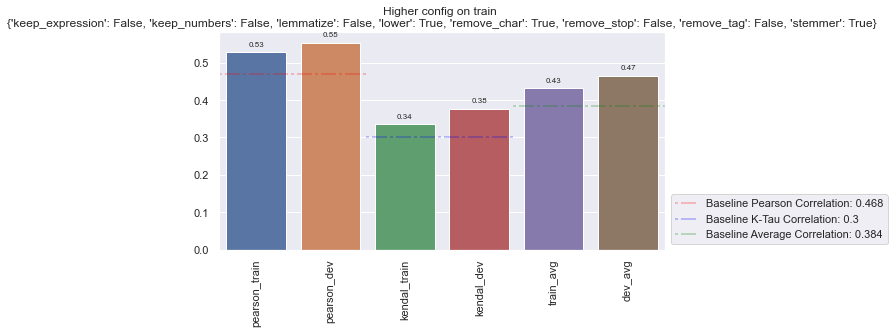

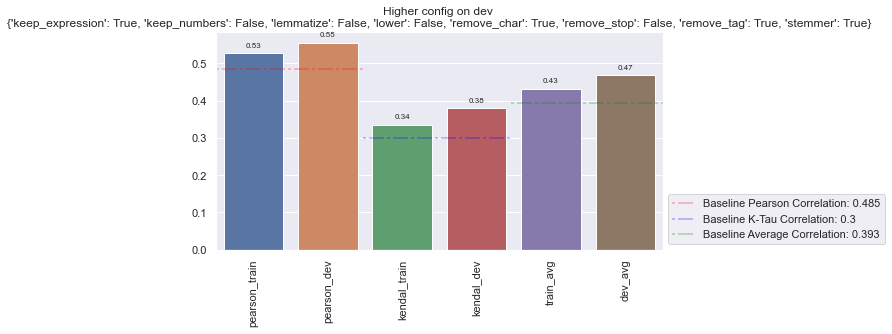

In [57]:
sns.set(rc={"figure.figsize":(8, 4)})

for data_type in ['train', 'dev']:
    col_list = ['pearson_train' ,'pearson_dev' ,'kendal_train' ,'kendal_dev' ,'train_avg' ,'dev_avg']
    fig = sns.barplot(finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,8:][col_list].index,
                      finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,8:][col_list].values)
    # Iterrating over the bars one-by-one
    for bar in fig.patches:
        fig.annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
    fig.set_title(f'Higher config on {data_type} \n' + str(dict(finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0, 0:8])))
    
    if data_type == 'train':
        
        baseline_pearson = 0.4683911953347246
        baseline_ktau = 0.300046314649797
        
    else:
        
        baseline_pearson = 0.4849728233340249
        baseline_ktau = 0.300046314649797
        
    avg = (baseline_pearson+baseline_ktau)/2
        
    line1 = plt.axhline(baseline_pearson, 0, 0.33, color = 'red', alpha = 0.3, label = f'Baseline Pearson Correlation: {round(baseline_pearson,3)}')
    line1.set_dashes([2, 2, 10, 2])
    
    line2 = plt.axhline(baseline_ktau, 0.33, 0.66, color = 'blue', alpha = 0.3, label = f'Baseline K-Tau Correlation: {round(baseline_ktau,3)}')
    line2.set_dashes([2, 2, 10, 2])
    
    line3 = plt.axhline(avg, 0.66, 1, color = 'green', alpha = 0.3, label = f'Baseline Average Correlation: {round(avg,3)}')
    line3.set_dashes([2, 2, 10, 2])
    
    plt.legend(bbox_to_anchor=(1,0), loc = 'lower left')
    plt.show()

In [18]:
parameters_ch = {'keep_numbers': [True, False],
                  'remove_punctuation': [True, False],
                  'remove_stop': [True, False],
                  'stopwords_set': ['merged', 'fst', 'snd']}

parameters_ch = pd.DataFrame(list(ParameterGrid(parameters_ch)))

In [19]:
for conf in range(parameters_ch.shape[0]):
    sets = ['train', 'dev']
    cleaned_data = pd.DataFrame()
    cleaned_data['z-score'] = chinese['z-score']
    for column in ['reference', 'translation']:
        cleaned_data[column] = clean_ch(chinese[column],
                                    keep_numbers = parameters_ch.loc[conf, 'keep_numbers'],
                                    remove_punctuation = parameters_ch.loc[conf, 'remove_punctuation'],
                                    remove_stop = parameters_ch.loc[conf, 'remove_stop'],
                                    stopwords_set = parameters_ch.loc[conf, 'stopwords_set'])
    
    ch_train, ch_dev = train_test_split(cleaned_data, shuffle = True, test_size = 0.2, random_state = 7)
    ch_dev, ch_test = train_test_split(ch_dev, shuffle = True, test_size = 0.5, random_state = 7)
    
    ch_train_bl_encoded, ch_dev_bl_encoded, ch_test_bl_encoded = dataVectorization(ch_train, ch_dev, ch_test)
    
    y_train_label = np.array(ch_train['z-score'])
    chinese_train_pearson, chinese_train_kendalltau = getBaseline(ch_train_bl_encoded[0], ch_train_bl_encoded[1], y_train_label)
    parameters_ch.loc[conf, ['pearson_train', 'kendal_train']] = chinese_train_pearson[0], chinese_train_kendalltau[0]
    
    y_dev_label = np.array(ch_dev['z-score'])
    chinese_dev_pearson, chinese_dev_kendalltau = getBaseline(ch_dev_bl_encoded[0], ch_dev_bl_encoded[1], y_dev_label)
    parameters_ch.loc[conf, ['pearson_dev', 'kendal_dev']] = chinese_dev_pearson[0], chinese_dev_kendalltau[0]
    
parameters_ch.to_csv('grid_parameters_chinese.csv')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\anton\AppData\Local\Temp\jieba.cache
Loading model cost 0.561 seconds.
Prefix dict has been built successfully.


In [20]:
chineseDf = pd.read_csv('grid_parameters_chinese.csv', index_col = 0)

In [21]:
chineseDf['train_avg'] = (chineseDf['pearson_train'] + chineseDf['kendal_train']) / 2
chineseDf['dev_avg'] = (chineseDf['pearson_dev'] + chineseDf['kendal_dev']) / 2

In [64]:
chineseDf.sort_values(f'train_avg', ascending=False).iloc[0:5,]

keep_numbers  remove_punctuation  remove_stop stopwords_set  \
8           True               False         True           snd   
2           True                True         True           snd   
14         False                True         True           snd   
20         False               False         True           snd   
19         False               False         True           fst   

    pearson_train  kendal_train  pearson_dev  kendal_dev  train_avg   dev_avg  
8        0.385485      0.254399     0.414134    0.284223   0.319942  0.349178  
2        0.385649      0.253712     0.415267    0.283750   0.319681  0.349509  
14       0.384114      0.252620     0.414883    0.286929   0.318367  0.350906  
20       0.383702      0.252836     0.417410    0.286903   0.318269  0.352156  
19       0.373498      0.248094     0.413243    0.280184   0.310796  0.346714

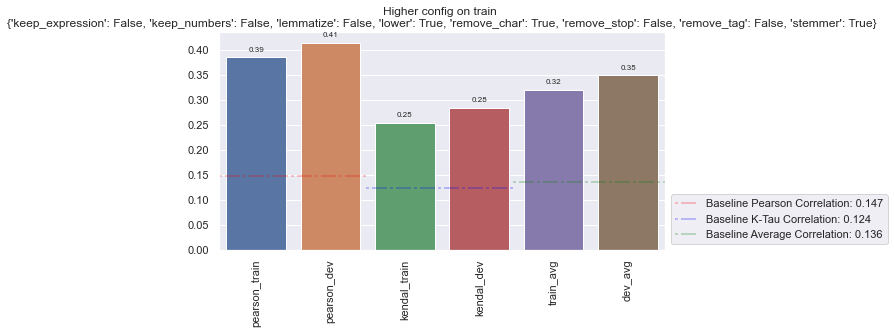

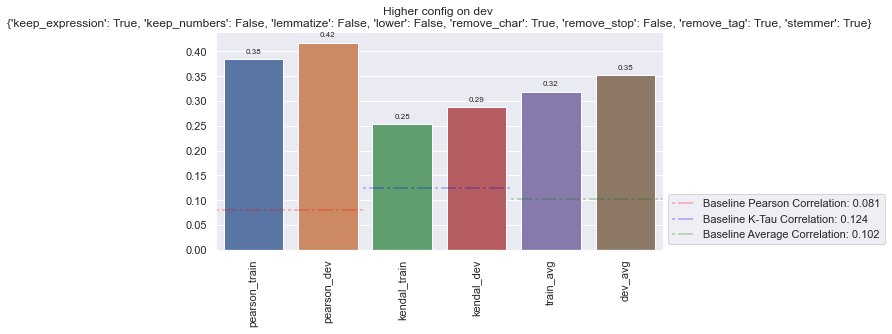

In [62]:
sns.set(rc={"figure.figsize":(8, 4)})

for data_type in ['train', 'dev']:
    col_list = ['pearson_train' ,'pearson_dev' ,'kendal_train' ,'kendal_dev' ,'train_avg' ,'dev_avg']
    fig = sns.barplot(chineseDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,4:][col_list].index,
                      chineseDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,4:][col_list].values)
    # Iterrating over the bars one-by-one
    for bar in fig.patches:
        fig.annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
    fig.set_title(f'Higher config on {data_type} \n' + str(dict(finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0, 0:8])))
    
    if data_type == 'train':
        
        baseline_pearson = 0.1473916639615326
        baseline_ktau = 0.12438157343879563
        
    else:
        
        baseline_pearson = 0.08052579663476413
        baseline_ktau = 0.12438157343879563
        
    avg = (baseline_pearson+baseline_ktau)/2
        
    line1 = plt.axhline(baseline_pearson, 0, 0.33, color = 'red', alpha = 0.3, label = f'Baseline Pearson Correlation: {round(baseline_pearson,3)}')
    line1.set_dashes([2, 2, 10, 2])
    
    line2 = plt.axhline(baseline_ktau, 0.33, 0.66, color = 'blue', alpha = 0.3, label = f'Baseline K-Tau Correlation: {round(baseline_ktau,3)}')
    line2.set_dashes([2, 2, 10, 2])
    
    line3 = plt.axhline(avg, 0.66, 1, color = 'green', alpha = 0.3, label = f'Baseline Average Correlation: {round(avg,3)}')
    line3.set_dashes([2, 2, 10, 2])
    
    plt.legend(bbox_to_anchor=(1,0), loc = 'lower left')
    plt.show()